In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
Mau_file = ".\\Parsed_Capuchinbird_Clips\\XC114131-0.wav"
N_Mau_file = ".\\Parsed_Not_Capuchinbird_Clips\\afternoon-birds-song-in-forest-0.wav"

## Construir a Função de Loading dos Dados

In [3]:
def load_wav_16k_mono(filename):
    # Carrega o arquivo wav
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Vai de 44,1kHz para 16khz - amplitude do sinal de áudio
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
mau_wave = load_wav_16k_mono(Mau_file)
n_mau_wave = load_wav_16k_mono(N_Mau_file)

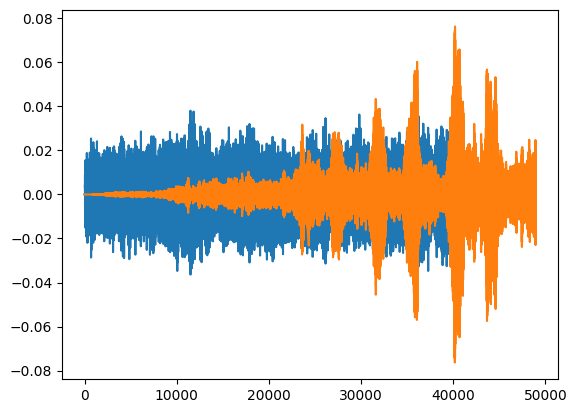

In [49]:
plt.plot(mau_wave)
plt.plot(n_mau_wave)
plt.show() 

# Criar o Dataset para o Tenserflow

In [10]:
POS = os.path.join('.\Parsed_Capuchinbird_Clips')
NEG = os.path.join('.\Parsed_Not_Capuchinbird_Clips')

In [11]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [12]:
positivos = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negativos = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positivos.concatenate(negativos)

# Determinar o comprimento médio do canto do Maú

In [16]:
comp = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join('.\Parsed_Capuchinbird_Clips', file))
    comp.append(len(tensor_wave))

In [17]:
tf.math.reduce_mean(comp)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

Em média o canto do Maú tem 3.384 segundos de duração

In [18]:
tf.math.reduce_min(comp)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

O mínimo é 2 segundos

In [19]:
tf.math.reduce_max(comp)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

E o máximo é 5 segundos

#Costruir a função para converter para espectrograma

In [20]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    espectrograma = tf.signal.stft(wav, frame_length=320, frame_step=32) #transformada de Fourier do sinal
    espectrograma = tf.abs(espectrograma)
    espectrograma = tf.expand_dims(espectrograma, axis=2)
    return espectrograma, label

In [21]:
filepath, label = positivos.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [22]:
spectrogram, label = preprocess(filepath, label)

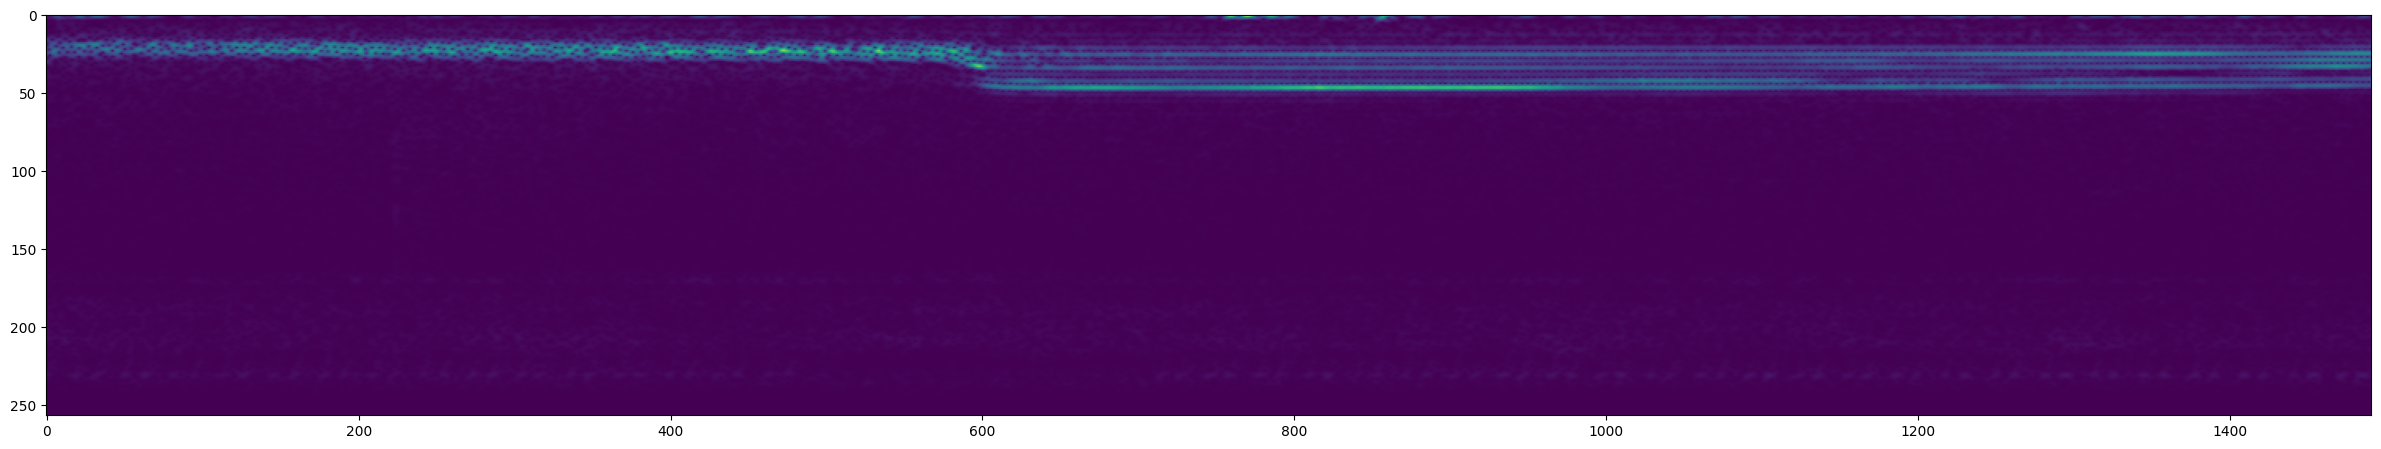

In [23]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Criar as partições de treino e teste

In [24]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
train = data.take(36)
test = data.skip(36).take(15)

In [26]:
samples, labels = train.as_numpy_iterator().next()

In [56]:
samples.shape

(16, 1491, 257, 1)

# Modelo de Deep Learnig

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [33]:
modelo =  Sequential()
modelo.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
modelo.add(Conv2D(16, (3, 3), activation='relu'))
modelo.add(Flatten())
modelo.add(Dense(128, activation='relu'))
modelo.add(Dense(1, activation='sigmoid'))

In [34]:
modelo.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [36]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_6 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten_2 (Flatten)         (None, 6019376)           0         
                                                                 
 dense_3 (Dense)             (None, 128)               770480256 
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [37]:
hist = modelo.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 1834s 51s/step - loss: 6.1704 - recall: 0.9108 - precision: 0.8125 - val_loss: 0.4991 - val_recall: 1.0000 - val_precision: 0.9048
Epoch 2/4
36/36 [==============================] - 1779s 49s/step - loss: 0.1644 - recall: 0.9608 - precision: 0.9608 - val_loss: 0.0474 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 1755s 49s/step - loss: 0.0581 - recall: 0.9932 - precision: 0.9864 - val_loss: 0.0639 - val_recall: 0.9833 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 1749s 49s/step - loss: 0.0385 - recall: 0.9936 - precision: 1.0000 - val_loss: 0.0308 - val_recall: 1.0000 - val_precision: 1.0000


In [38]:
X_test, y_test = test.as_numpy_iterator().next()

In [42]:
yhat = modelo.predict(X_test)

1/1 [==============================] - 1s 665ms/step


In [44]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [45]:
yhat

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [47]:
y_test.astype(int)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])